In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. Cargar dataframe con el corpus

In [2]:
df = pd.read_excel('DATA/corpus2.xlsx')
df.sample(3)

,Unnamed: 0,Exc_register_id,Exc_patientCenter_id,Exc_texto_relleno,TEXTO_SIN_STOPWORDS,texto_tokenizado,Num_palabras,Mexico02,Mexico01,CurrentActivity,...,CSSRS06,CSSRS07,NSSIIS01B_Sometimes,NSSIIS01B_Last_Month_nb,T_WHODAS,T_PHQ_9,T_GAD_2,T_DAST,T_ALC,BMI
560,1370,5de9979d2fc67632f177fdea,83226,No han sido unos meses buenos para mi pero soy...,sido meses buenos capaz salir dominar mente ve...,"['sido', 'meses', 'buenos', 'capaz', 'salir', ...",9,Si,Si,Estudiante,...,No,NaN,No,0,57.0,6.0,1.0,NaN,8.0,25.099502
298,775,5ddebf572fc67626586ef73f,82254,PUES QUE LA ENCUESTA ESTÁ BIEN PARA CONOCER EL...,pues encuesta bien conocer ánimo cada persona ...,"['pues', 'encuesta', 'bien', 'conocer', 'ánimo...",10,Si,No,Estudiante,...,No,NaN,No,0,88.2,1.0,0.0,NaN,0.0,26.528510
385,935,5dd564672fc676223c4849ad,80440,Por cuestiones de exámenes y por enfermedad só...,cuestiones exámenes enfermedad sólo podido dor...,"['cuestiones', 'exámenes', 'enfermedad', 'sólo...",9,Si,Si,Estudiante,...,No,NaN,No,0,90.2,2.0,0.0,2.0,4.0,39.062500


Definimos la columna de texto y de etiqueta

In [3]:
text_col_name = "TEXTO_SIN_STOPWORDS"
label_col_name = "T_GAD_2"

Eliminar las columnas sin etiqueta

In [4]:
df.dropna(subset=[label_col_name],inplace=True)
df.reset_index(drop=True,inplace=True)

# 1. Obtener palabras prototípicas

In [5]:
from SentimentKW import KW

keywords = KW(df,text_col_name=text_col_name, label_col_name=label_col_name)

/home/wini/.local/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wini/.local/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wini/.local/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wini/.local/lib/python3.8/site-packages/tensorboard/compat/tensorflow_

In [6]:
W0 = keywords.get_kw(topn=100)
list(W0.items())[:10]

[('emocionalmente', -0.14809844998105143),
 ('llegado', -0.09607385741815412),
 ('dos', -0.19999999887944073),
 ('dormido', -0.24603174552463677),
 ('1', -0.21070685294285252),
 ('sociedad', -0.36681397422681805),
 ('sistema', -0.2375631894335679),
 ('voy', -0.21211158183308065),
 ('esperanza', -0.1936855445400245),
 ('país', 0.2618617641912693)]

# 2. Entrenar modelo de word2vec

In [25]:
from gensim.models import Word2Vec

tokens = [x.split() for x in list(df[text_col_name].values)]
print(tokens[:2])

dim = 100
W2V_model = Word2Vec(tokens, min_count=1, vector_size=dim, workers=4, window=5)
W2V_model.save("DATA/w2v-TEXTO_SIN_STOPWORDS.model")

[['persona', 'hipersensible', 'extremadamente', 'emocional', 'asisto', 'terapia', 'dbt', 'dialectical', 'behavor', 'therapy', 'mejorado', 'manera', 'gradual', 'manejo', 'emociones', 'conductas'], ['mantengo', 'relaciones', 'sexuales', 'si', 'puse', 'si', 'estable']]


También se puede entrenar el módelo en FastText

In [98]:
from gensim.models import FastText

dim = 100
FT_model = FastText(tokens, min_count=1, vector_size=dim, workers=4, window=5)

# Suele ser un archivo grande
# FT_model.save("DATA/FT-TEXTO_SIN_STOPWORDS.model")   

# 3. Word Scoring

Más información y detalles sobre el uso de esta clase: [https://github.com/labsemco/word-scoring](https://github.com/labsemco/word-scoring)

Leemos el modelo pre-entrenado que vayamos a usar

In [7]:
from scoring import Scoring
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("DATA/w2v-TEXTO_SIN_STOPWORDS.model")

puntaje = Scoring(w2vmodel=w2v_model,W0=W0)

Si es la primera vez que se ejecuta, o se modificaron los embeddings o palabras prototípicas, correr esta celda:

In [8]:
puntaje.build_neighbors(alpha=0.5)

puntaje.save_neighbors("DATA/vecinos-dict.pickle")

Neighbors dictionary saved.


Si no se ha modificado los embeddings o las palabras prototípicas, puede leerse el diccionario de vecinos, para no calcularlo otra vez.

In [9]:
puntaje.load_neighbors("DATA/vecinos-dict.pickle")

Calcular el puntaje de palabras

In [10]:
scores_df = puntaje.transform(df=df,text_col=text_col_name,label_col=label_col_name,beta1=1,beta2=1)
scores_df.sort_values(by='score',ascending=False)

,word,score
955,maestro,0.999998
1365,migrañas,0.999993
1857,corté,0.999993
1877,departamento,0.999993
1875,borges,0.999993
...,...,...
634,cerveza,-0.547604
640,ciudad,-0.561240
855,cuadro,-0.586400
462,herramienta,-0.634413


# 4. Clasificación

In [26]:
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
  plt.figure(dpi=120)
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  new_xticks =  [str(int(x.get_text())+1) for x in hmap.xaxis.get_ticklabels()]
  new_yticks =  [str(int(x.get_text())+1) for x in hmap.yaxis.get_ticklabels()]
  hmap.xaxis.set_ticklabels(new_xticks, rotation=0, ha='right')
  hmap.yaxis.set_ticklabels(new_yticks, rotation=0, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## 4.1 Representación de textos usando promedios

Obtenemos una matriz de vectores de features representando a cada entidad de texto. Estas representaciones sirven para realizar la clasificación y predicción de etiquetas, usando métodos de ML.

Hay tres opciones:

* Representación promedio `get_texts_representations_mean()`
* Representación promedio parcial `get_texts_representations_Nmean()`
* Representación PCA `get_texts_representations_PCA()`

In [30]:
# Escoger una de las tres:

X = puntaje.get_texts_representations_mean()
# X = puntaje.get_texts_representations_Nmean(n=3)
# X = puntaje.get_texts_representations_PCA()

X[:3,:5]

array([[ 3.26507760e-04,  1.64398786e-04, -4.24194999e-07,
        -8.22981181e-05, -4.00654098e-04],
       [ 1.43637436e-03, -1.89211169e-03,  1.23054166e-05,
        -8.33063587e-04,  7.08011296e-04],
       [ 2.12547999e-03, -1.62139633e-03, -4.23365427e-04,
        -2.91242519e-05, -1.09895640e-03]])

La clasificación puede hacerse usando cualquier clasificador (k-nearest neighbors, Naive Bayes, xgboost, etc.). La implementación es similar a esta.

Accuracy: 0.3220338983050847
Recall: 0.20121566413126515
ROC: 0.5365423362165306


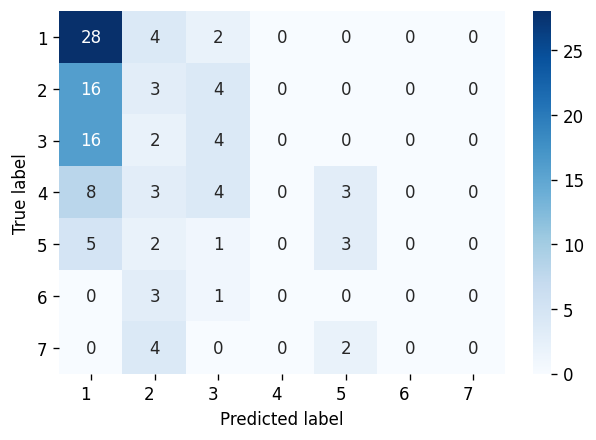

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,multilabel_confusion_matrix, roc_auc_score,confusion_matrix
from keras.utils import to_categorical

# Vector de etiquetas
y = df[label_col_name].values

# Entrenamiento y predicción
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=28)
svm = SVC(kernel='rbf', C=1)
svm_model = svm.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)

# Obtenemos las métricas de la clasificación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test,y_pred,average='macro')
roc = roc_auc_score(to_categorical(y_test, n_classes),
                    to_categorical(y_pred, n_classes),
                    multi_class="ovr")
cm = confusion_matrix(y_test,y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"ROC: {roc}")
show_confusion_matrix(cm)


## 4.2 Representaciones usando matrices y CNN

También puede hacerse la clasificación usando una red neuronal convolucional, usando representaciones matriciales de mensajes. 

IMPORTANTE: Necesita la tarjeta gráfica, puede correrse en colab.

In [12]:
from sklearn.model_selection import train_test_split

X = puntaje.get_texts_representations_MAT(cols_num=5)  # Puede experimentarse con el valor de cols_num, debe ser mayor o igual que 2.
y = df[label_col_name].values

print("X:",X.shape)
print("y:",y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

val_size = int(0.85*X_train.shape[0])
X_val = X_train[val_size:]
y_val = y_train[val_size:]
X_train = X_train[:val_size]
y_train = y_train[:val_size]
print("Train:",X_train.shape,y_train.shape)
print("Validation:",X_val.shape,y_val.shape)
print("Test:",X_test.shape,y_test.shape)

X: (781, 100, 5)
y: (781,)
Train: (530, 100, 5) (530,)
Validation: (94, 100, 5) (94,)
Test: (157, 100, 5) (157,)


In [13]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

n_classes = len(keywords.labels)

print(f"Las representaciones de los mensajes son de {X_train.shape[0]}x{X_train.shape[1]}")

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', 
                            input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# entrenar el modelo:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=16, epochs=200, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

score = model.evaluate(X_test, Y_test)

Using TensorFlow backend.


Las representaciones de los mensajes son de 530x100
Shape before one-hot encoding:  (530,)
Shape after one-hot encoding:  (530, 7)
Train on 530 samples, validate on 94 samples
Epoch 1/200
530/530 [==============================] - 1s 2ms/step - loss: 1.7859 - accuracy: 0.2623 - val_loss: 1.7101 - val_accuracy: 0.2979
Epoch 2/200
530/530 [==============================] - 0s 269us/step - loss: 1.6568 - accuracy: 0.3226 - val_loss: 1.5946 - val_accuracy: 0.2979
Epoch 3/200
530/530 [==============================] - 0s 319us/step - loss: 1.6028 - accuracy: 0.3509 - val_loss: 1.5766 - val_accuracy: 0.3085
Epoch 4/200
530/530 [==============================] - 0s 283us/step - loss: 1.5175 - accuracy: 0.3906 - val_loss: 1.5889 - val_accuracy: 0.3085
Epoch 5/200
530/530 [==============================] - 0s 283us/step - loss: 1.4361 - accuracy: 0.4736 - val_loss: 1.5784 - val_accuracy: 0.3085
Epoch 6/200
530/530 [==============================] - 0s 258us/step - loss: 1.3698 - accuracy: 0.494

Graficamos las curvas de entrenamiento

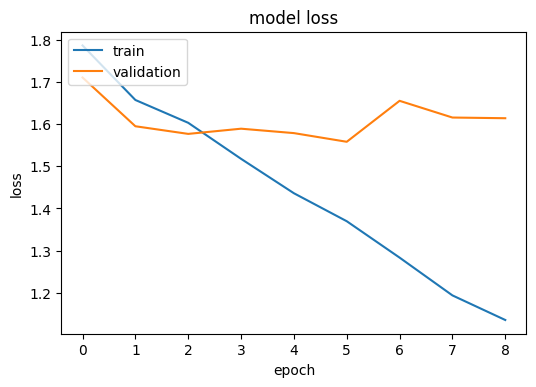

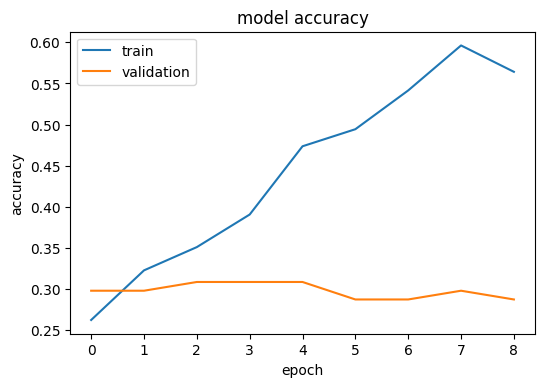

In [20]:
plt.figure(dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=100)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Test loss: 1.805
Test accuracy: 31.85%
ROC: 0.6091924209584624
Accuracy: 0.3184713375796178
Recall: 0.18933020882771712


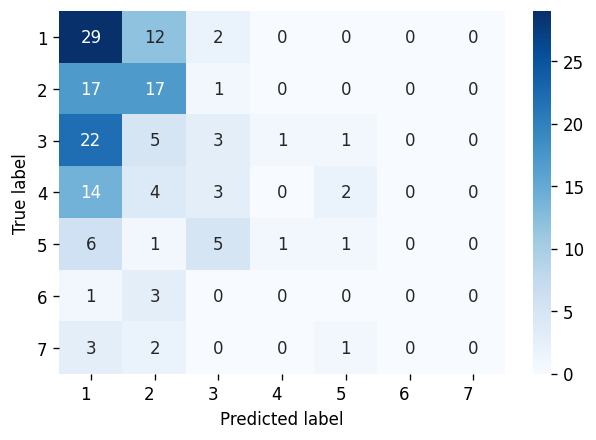

In [30]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
from keras.utils import to_categorical

print (f"Test loss: {round(score[0],3)}")
print (f"Test accuracy: {round(score[1]*100,2)}%")

Y_pred = model.predict(X_test)

roc = roc_auc_score(Y_test,Y_pred,multi_class="ovr")
accuracy = accuracy_score(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
recall = recall_score(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1),average='macro')
cm = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))

print(f"ROC: {roc}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
show_confusion_matrix(cm)